鈴木讓「統計的機械学習の数理 with Python 100問」(共立出版)

# 第2章 分類

## 2.1 ロジスティック曲線

In [1]:
! pip install japanize_matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# import japanize_matplotlib
import scipy
from scipy import stats
from numpy.random import randn #正規乱数

In [3]:
# Anacondaの場合は下記( import japanize_matplotlib はコメントアウト)
import matplotlib
from matplotlib import font_manager
matplotlib.rc("font", family="BIZ UDGothic")

In [4]:
def f(x):
    return np.exp(beta_0 + beta * x) / (1 + np.exp(beta_0 + beta * x))

In [5]:
beta_0 = 0
beta_seq = np.array([0, 0.2, 0.5, 1, 2, 10])
x_seq = np.arange(-10, 10, 0.1)
plt.xlabel("x")
plt.ylabel("P(Y=1|x)")
plt.title("ロジスティック曲線")
for beta in beta_seq:
    p = f(x_seq)
    plt.plot(x_seq, p, label=f'{beta}')
plt.legend(loc='upper left')
plt.show()

## 2.2 Newton-Rapson法の適用

In [6]:
def f(x):
    return x ** 2 - 1

def df(x):
    return 2 * x

In [7]:
x_seq = np.arange(-1, 5, 0.1)
f_x = f(x_seq)
plt.plot(x_seq, f_x)
plt.axhline(y=0, c="black", linewidth=0.5)
plt.xlabel("x")
plt.ylabel("f(x)")

x = 4
for i in range(10):
    X, Y = x, f(x)  # 更新前の点
    x = x - f(x) / df(x)  # x 更新後
    plt.plot([X, x], [Y, 0], c="black", linewidth=0.8)
    plt.plot([X, X], [Y, 0], c="black", linestyle="dashed", linewidth=0.8)
    plt.scatter(x, 0, c="red")
plt.show()

In [8]:
def f(z):
    """関数fの定義: 二変数関数f(z) = z[0]^2 + z[1]^2 - 1"""
    return z[0]**2 + z[1]**2 - 1

def dfx(z):
    """関数fに対するxによる偏微分"""
    return 2 * z[0]

def dfy(z):
    """関数fに対するyによる偏微分"""
    return 2 * z[1]

def g(z):
    """関数gの定義: g(z) = z[0] + z[1]"""
    return z[0] + z[1]

def dgx(z):
    """関数gに対するxによる偏微分"""
    return 1

def dgy(z):
    """関数gに対するyによる偏微分"""
    return 1

数値解析による解の更新

In [9]:
z = np.array([3, 4])  # 初期値
for i in range(10):
    J = np.array([[dfx(z), dfy(z)], [dgx(z), dgy(z)]])
    z = z - np.linalg.inv(J) @ np.array([f(z), g(z)])
print(z)

[-0.70710678  0.70710678]


ロジスティック回帰によるデータの生成と最尤推定

In [10]:
N = 1000
p = 2
X = randn(N, p)
X = np.insert(X, 0, 1, axis=1)  # 定数項を追加
beta = randn(p + 1)
y = []
prob = 1 / (1 + np.exp(-X @ beta))
for i in range(N):
    y.append(1 if np.random.rand() > prob[i] else -1)

print(beta)  # 確認

[-1.50613263 -0.23956311 -1.08266016]


In [11]:
# 最尤推定
gamma = randn(p + 1)  # betaの初期値
print(gamma)
while np.sum((beta - gamma) ** 2) > 0.001:
    beta = gamma
    s = X @ beta
    v = np.exp(-s * np.array(y))
    u = (np.array(y) * v) / (1 + v)
    w = v / ((1 + v) ** 2)
    W = np.diag(w)
    z = s + u / w
    gamma = np.linalg.inv(X.T @ W @ X) @ X.T @ W @ z
    print(gamma)

[ 1.21610641  1.57448368 -0.16447689]
[ 0.6641686  -0.72883734  1.16535553]
[1.27103622 0.31758491 0.70661174]
[1.36065492 0.22975493 0.99249824]
[1.38842151 0.22852262 1.02660363]
[1.38900515 0.22855143 1.02729591]


In [12]:
# データの生成
n = 100
x = np.concatenate([randn(n) + 1, randn(n) - 1], 0)
y = np.concatenate([np.ones(n), -np.ones(n)], 0)

train = np.random.choice(2 * n, int(n), replace=False)  # 訓練データの添え字
test = list(set(range(2 * n)) - set(train))  # テストデータの添え字
X = np.insert(x[train].reshape(-1, 1), 0, 1, axis=1)
Y = y[train]

In [13]:
# gammaの初期値によっては収束しないので、複数回施行することがある
p = 1
beta = [0, 0]
gamma = np.random.randn(p + 1)
print(gamma)
while (np.sum((beta - gamma) ** 2) > 0.001):
    beta = gamma
    s = X @ beta
    v = np.exp(-s * Y)
    u = (Y * v) / (1 + v)
    w = v / ((1 + v) ** 2)
    W = np.diag(w)
    z = s + u / w
    gamma = np.linalg.inv(X.T @ W @ X) @ X.T @ W @ z
    print(gamma)

[1.30048206 0.33237404]
[0.34933213 1.45800817]
[0.4590486  2.06309156]
[0.52852174 2.37996988]
[0.54398809 2.44494359]
[0.54453978 2.44715953]


In [14]:
def table_count(m, u, v):
    n = u.shape[0]
    count = np.zeros([m, m])
    for i in range(n):
        count[int(u[i]), int(v[i])] += 1
    return count

In [15]:
ans = y[test]  # 正解
pred = np.sign(gamma[0] + x[test] * gamma[1])  # 予測
ans = (ans + 1) / 2   # -1,1から0,1になおす
pred = (pred + 1) / 2   # -1,1から0,1になおす
confusion_matrix = table_count(2, ans, pred)

print(confusion_matrix)

[[42.  9.]
 [ 3. 46.]]


## 2.3 線形判別と２次判別

In [16]:
# 真のパラメータ
mu_1 = np.array([2, 2])
sigma_1 = 2
sigma_2 = 2
rho_1 = 0
mu_2 = np.array([-3, -3])
sigma_3 = 1
sigma_4 = 1
rho_2 = -0.8

# 真のパラメータに基づいてデータを発生
n = 100
u = randn(n)
v = randn(n)
x_1 = sigma_1 * u + mu_1[0]
y_1 = (rho_1 * u + np.sqrt(1 - rho_1**2) * v) * sigma_2 + mu_1[1]
u = randn(n)
v = randn(n)
x_2 = sigma_3 * u + mu_2[0]
y_2 = (rho_2 * u + np.sqrt(1 - rho_2**2) * v) * sigma_4 + mu_2[1]

# データからパラメータを推定
mu_1 = np.average((x_1, y_1), axis=1)
mu_2 = np.average((x_2, y_2), axis=1)

df_1 = np.array([x_1, y_1])          #
mat_1 = np.cov(df_1, rowvar=True)    #
inv_1 = np.linalg.inv(mat_1)         #
de_1 = np.linalg.det(mat_1)          #

df_2 = np.array([x_2, y_2])          #
mat_2 = np.cov(df_2, rowvar=True)    #
inv_2 = np.linalg.inv(mat_2)         #
de_2 = np.linalg.det(mat_2)          #


In [17]:
# 推定されたパラメータを分布の式に代入
def f(x, mu, inv, de):
    return -0.5 * (x - mu).T @ inv @ (x - mu) - 0.5 * np.log(de)

def f_1(u, v):
    return f(np.array([u, v]), mu_1, inv_1, de_1)

def f_2(u, v):
    return f(np.array([u, v]), mu_2, inv_2, de_2)

In [18]:
# 等高線データを作成
pi_1 = 0.5
pi_2 = 0.5
u = v = np.linspace(-6, 6, 50)
m = len(u)
w = np.zeros([m, m])
for i in range(m):
    for j in range(m):
        w[i, j] = np.log(pi_1) + f_1(u[i], v[j]) - np.log(pi_2) - f_2(u[i], v[j])

# 境界線とデータをプロット
plt.contour(u, v, w, levels=[0], colors=['black'])
plt.scatter(x_1, y_1, c="red")
plt.scatter(x_2, y_2, c="blue")
plt.show()

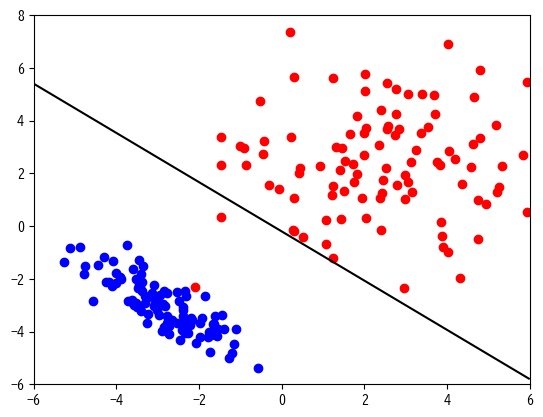

In [19]:
# データの前処理
xx = np.concatenate((x_1 - mu_1[0], x_2 - mu_2[0]), axis=0).reshape(-1, 1)
yy = np.concatenate((y_1 - mu_1[1], y_2 - mu_2[1]), axis=0).reshape(-1, 1)
df = np.concatenate((xx, yy), axis=1)  # データを縦方向に結合

# 共分散行列の計算
mat = np.cov(df, rowvar=False)  # 縦方向のデータなのでrowvarをFalseに設定
inv_1 = np.linalg.inv(mat)
de_1 = np.linalg.det(mat)
inv_2 = inv_1
de_2 = de_1

# 等高線用の重み計算
w = np.zeros((m, m))
for i in range(m):
    for j in range(m):
        w[i, j] = np.log(pi_1) + f_1(u[i], v[j]) - np.log(pi_2) - f_2(u[i], v[j])

# 等高線とデータのプロット
plt.contour(u, v, w, levels=[1], colors='black')
plt.scatter(x_1, y_1, color="red")
plt.scatter(x_2, y_2, color="blue")
plt.show()

In [20]:
from sklearn.datasets import load_iris

In [21]:
# アイリスデータセットを用いた分類
iris = load_iris()
x = iris.data
y = iris.target
n = len(x)
train = np.random.choice(n, int(n / 2), replace=False)
test = list(set(range(n)) - set(train))

# パラメータを推定する
X = x[train, :]
Y = y[train]
mu = []
covv = []
for j in range(3):
    xx = X[Y == j, :]
    mu.append(np.mean(xx, 0))
    covv.append(np.cov(xx, rowvar=0))

In [22]:
# 推定されたパラメータを代入する分布の定義式
def f(w, mu, inv, de):
    """
    多変量正規分布の確率密度関数を計算する関数。

    Parameters:
    - w: 観測データのベクトル。
    - mu: 平均ベクトル。
    - inv: 共分散行列の逆行列。
    - de: 共分散行列の行列式。

    Returns:
    - 多変量正規分布の確率密度関数の値。
    """
    return -0.5 * (w - mu).T @ inv @ (w - mu) - 0.5 * np.log(de)

def g(v, j):
    """
    分布関数fを使用して特定のクラスjに対するデータvの確率密度を計算する関数。

    Parameters:
    - v: 観測データのベクトル。
    - j: 計算するクラスのインデックス。

    Returns:
    - クラスjに対するデータvの確率密度。
    """
    return f(v, mu[j], np.linalg.inv(covv[j]), np.linalg.det(covv[j]))

In [23]:
# テストデータに対するクラス予測
z = []
for i in test:
    z.append(np.argsort([-g(x[i, ], 0), -g(x[i, ], 1), -g(x[i, ], 2)])[0])

# 混同行列の計算
confusion_matrix = table_count(3, y[test], z)

print(confusion_matrix)

[[25.  0.  0.]
 [ 0. 24.  2.]
 [ 0.  0. 24.]]


## 2.4  K近傍法

In [24]:
def knn_1(x, y, z, k):
    """
    k-最近傍法を用いて、単一の観測データzに対するクラスを予測する関数。

    Parameters:
    - x: トレーニングデータセット。
    - y: トレーニングデータセットのラベル。
    - z: クラスを予測する観測データ。
    - k: 最近傍の数。

    Returns:
    - 予測されたクラスラベル。
    """
    x = np.array(x)
    y = np.array(y)
    dis = [np.linalg.norm(z - x[i, ]) for i in range(x.shape[0])]
    S = np.argsort(dis)[:k]  # 距離が近いk個のインデックス
    u = np.bincount(y[S])  # 度数を数える
    m = [i for i, val in enumerate(u) if val == max(u)]  # 最頻値のインデックス

    # タイブレーキングの処理 (最頻値が2個以上ある場合)
    while len(m) > 1:
        k -= 1
        S = S[:k]
        u = np.bincount(y[S])
        m = [i for i, val in enumerate(u) if val == max(u)]

    return m[0]

In [25]:
def knn(x, y, z, k):
    """
    k-最近傍法を用いて、複数の観測データに対するクラスを予測する関数。

    Parameters:
    - x: トレーニングデータセット。
    - y: トレーニングデータセットのラベル。
    - z: クラスを予測する観測データのセット。
    - k: 最近傍の数。

    Returns:
    - 予測されたクラスラベルのリスト。
    """
    return [knn_1(x, y, z[i, ], k) for i in range(z.shape[0])]

In [26]:
from sklearn.datasets import load_iris

In [27]:
# Irisデータセットの読み込み
iris = load_iris()
x = iris.data
y = iris.target

n = x.shape[0]
train = np.random.choice(n, int(n / 2), replace=False)
test = list(set(range(n)) - set(train))

# k-最近傍法による分類
w = knn(x[train, ], y[train], x[test, ], k=3)

# 混同行列の計算と表示
confusion_matrix = table_count(3, y[test], w)
print(confusion_matrix)

[[23.  0.  0.]
 [ 0. 22.  1.]
 [ 0.  1. 28.]]


## 2.5 ROC曲線

In [28]:
# パラメータの設定
N_0 = 10000  # 正常な人の数
N_1 = 1000   # 病気の人の数
mu_0 = -1    # 正常な人の平均
mu_1 = 1     # 病気の人の平均
var_0 = 1    # 正常な人の分散
var_1 = 1    # 病気の人の分散

# データの生成
x = np.random.normal(mu_0, np.sqrt(var_0), N_0)
y = np.random.normal(mu_1, np.sqrt(var_1), N_1)

# 閾値のシーケンス
theta_seq = np.exp(np.arange(-10, 100, 0.1))

# False Positive Rate と True Positive Rate の計算
U = []; V = []
for theta in theta_seq:
    u = np.mean(stats.norm.pdf(x, mu_1, np.sqrt(var_1)) / stats.norm.pdf(x, mu_0, np.sqrt(var_0)) > theta)
    v = np.mean(stats.norm.pdf(y, mu_1, np.sqrt(var_1)) / stats.norm.pdf(y, mu_0, np.sqrt(var_0)) > theta)
    U.append(u); V.append(v)

In [29]:
auc = 0  # 面積を求める
for i in range(len(theta_seq) - 1):
    auc += np.abs(U[i + 1] - U[i]) * V[i]

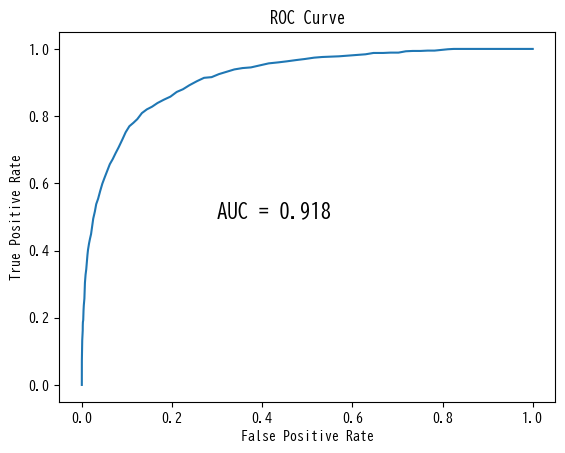

In [30]:
# ROC曲線のプロット
plt.plot(U, V)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.text(0.3, 0.5, 'AUC = {:.3f}'.format(auc), fontsize=15)
plt.show()